# Нейронки или градиентный бустинг? Что лучше для табличных биоданных?

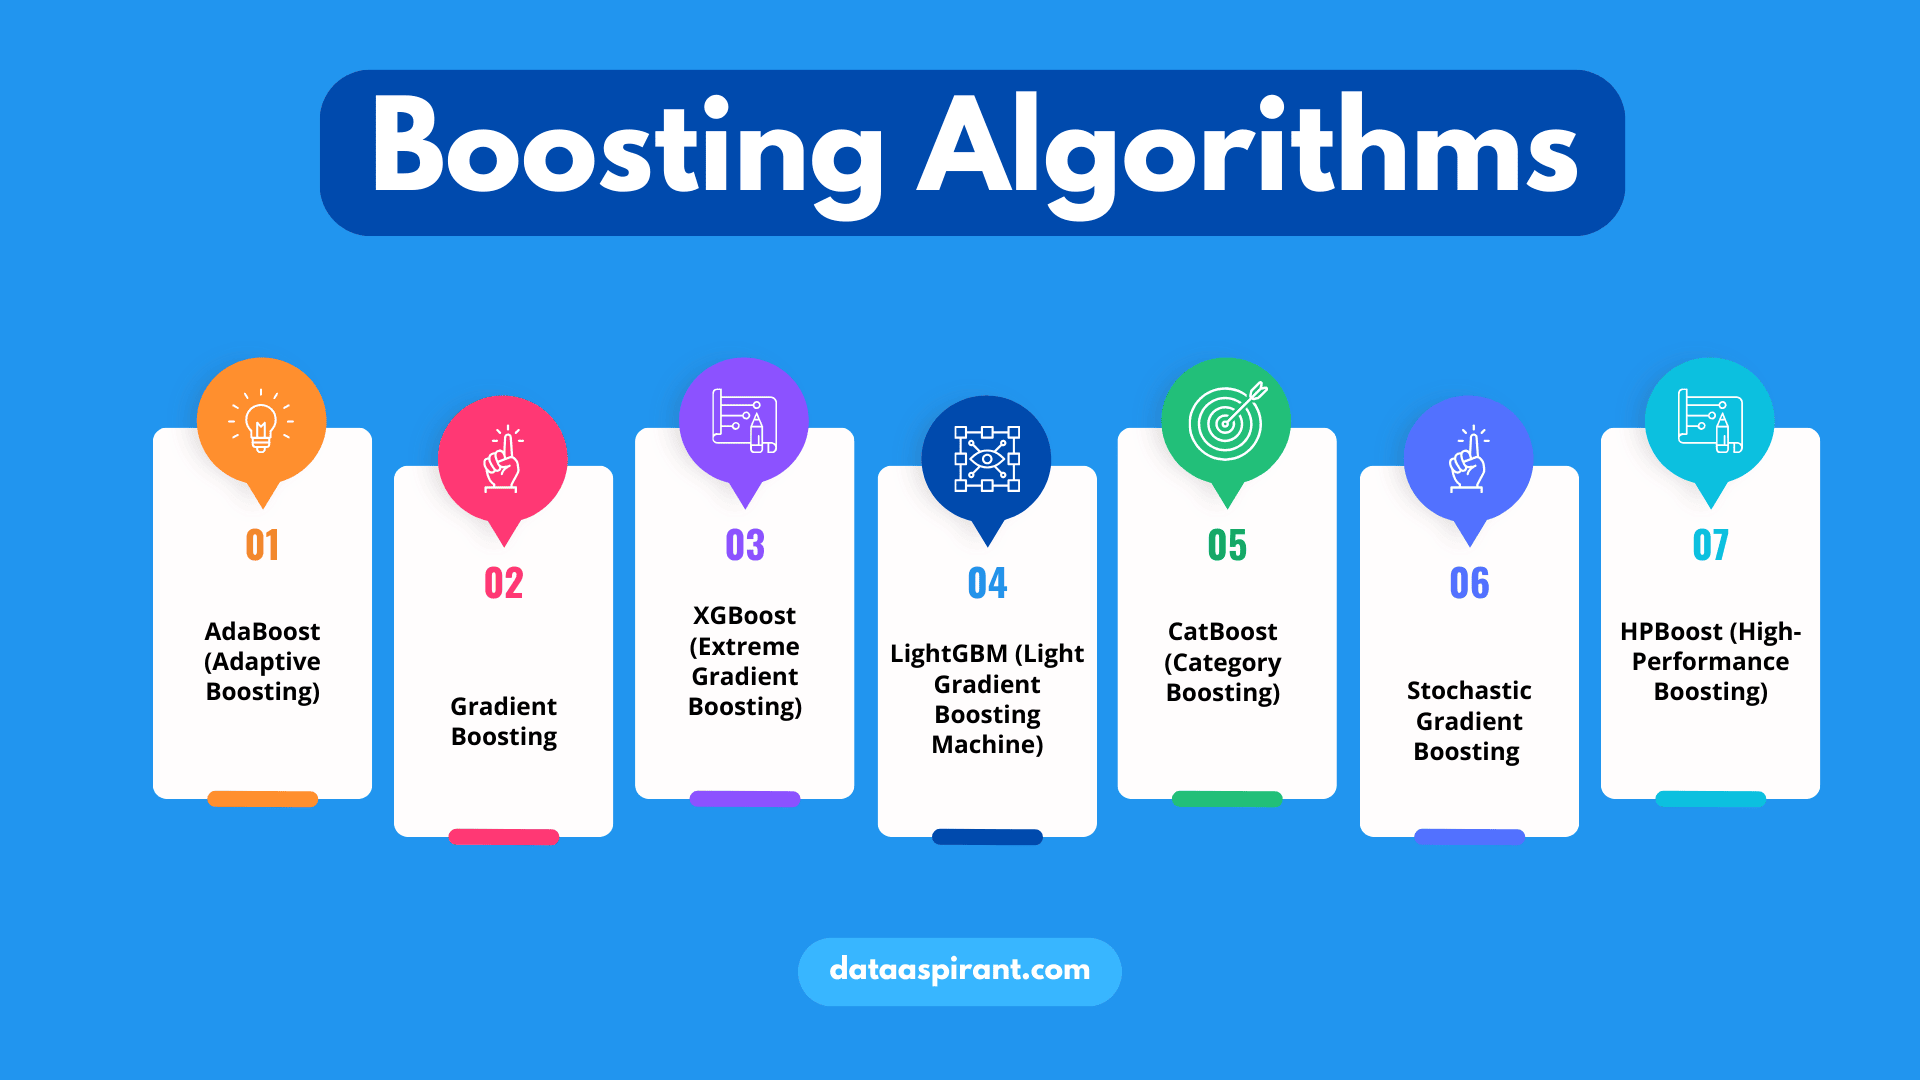

In [1]:
from IPython.display import Image
Image("figure1.png")

!pip install xgboost
!pip install lightgbm
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix , balanced_accuracy_score
from sklearn import tree
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV

## 1. Загрузка и обработка данных

Thyroid disease patient dataset
"Comprehensive Thyroid Diagnosis Dataset: Attributes and Classifications
https://www.kaggle.com/datasets/kapoorprakhar/thyroid-disease-patient-dataset?select=hypothyroid.csv

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head()

,Age,sex,thyroxine,queryonthyroxine,onantithyroidmedication,sick,pregnant,thyroidsurgery,I131treatment,queryhypothyroid,...,TT4measured,T4,T4Umeasured,T4U,FTImeasured,FTI,TBGmeasured,TBG,referral source,binaryClass
0,12,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,?,SVHC,P
1,20,M,f,f,f,f,f,f,f,f,...,t,102.0,f,0.00,f,0.0,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175.0,f,0.00,f,0.0,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,?,SVI,P


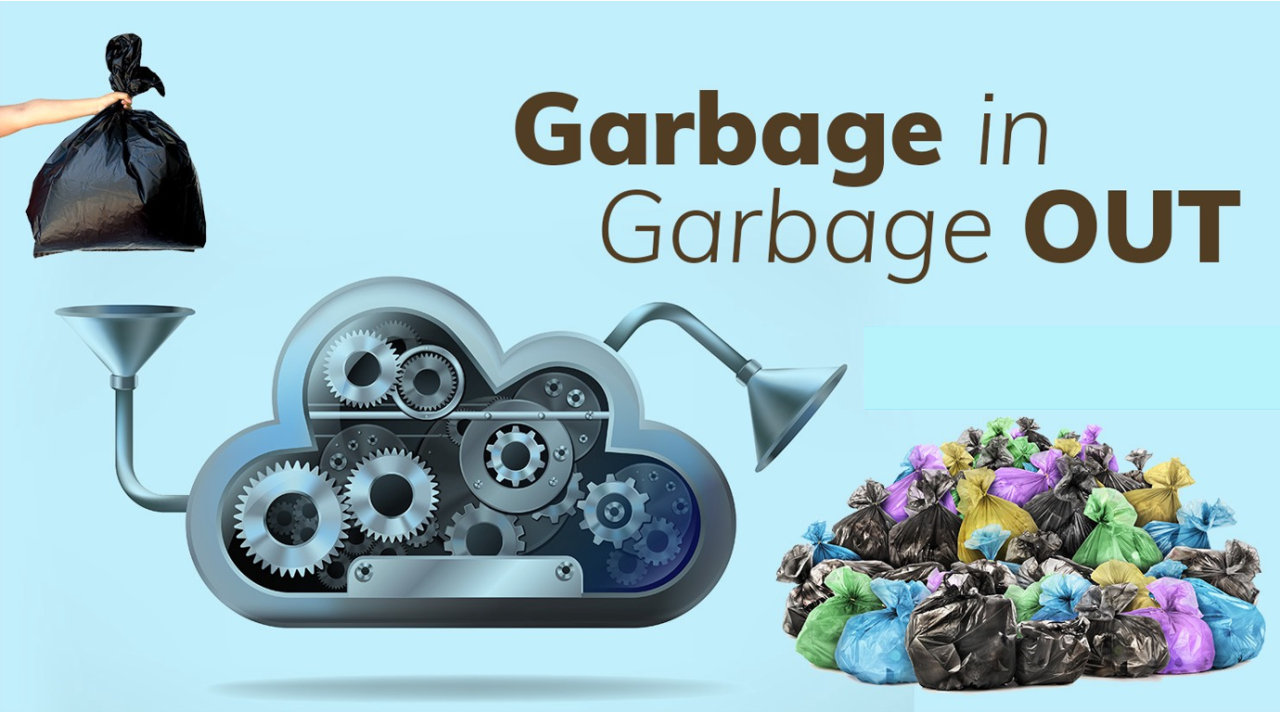

In [10]:
Image("figure2.png")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3770 entries, 0 to 3769
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      3770 non-null   int64  
 1   sex                      3620 non-null   object 
 2   thyroxine                3770 non-null   object 
 3   queryonthyroxine         3770 non-null   object 
 4   onantithyroidmedication  3770 non-null   object 
 5   sick                     3770 non-null   object 
 6   pregnant                 3770 non-null   object 
 7   thyroidsurgery           3770 non-null   object 
 8   I131treatment            3770 non-null   object 
 9   queryhypothyroid         3770 non-null   object 
 10  queryhyperthyroid        3770 non-null   object 
 11  lithium                  3770 non-null   object 
 12  goitre                   3770 non-null   object 
 13  tumor                    3770 non-null   object 
 14  hypopituitary           

In [6]:
columns_to_drop = ['referral source', 'TBG', 'TSHmeasured', 'T3measured', 'T4Umeasured','TT4measured', 'FTImeasured', 'TBGmeasured']
df.drop(columns=columns_to_drop, inplace=True)
df = df.replace({'f': 0, 't': 0})
df = df.replace({'F': 0, 'M': 1})
df = df.replace({'P': 0, 'N': 1})
df = df.dropna()
df['sex'] = df['sex'].astype(int)


C:\Users\demet\AppData\Local\Temp\ipykernel_16352\3629240392.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'f': 0, 't': 0})
C:\Users\demet\AppData\Local\Temp\ipykernel_16352\3629240392.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'F': 0, 'M': 1})
C:\Users\demet\AppData\Local\Temp\ipykernel_16352\3629240392.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=

In [8]:
(df['binaryClass'].sum()/df.shape[0])*100

7.734806629834254

In [9]:
#Нормализация данных
df[['TSH', 'T3', 'T4', 'T4U', 'FTI']]=(df[['TSH', 'T3', 'T4', 'T4U', 'FTI']]-df[['TSH', 'T3', 'T4', 'T4U', 'FTI']].mean())/df[['TSH', 'T3', 'T4', 'T4U', 'FTI']].std()

## 2. Кросс валидация и оценка моделей

In [11]:
def cross_val_func(model, X, y):
    scores_acc = cross_val_score(model, X, y, cv=4, scoring='balanced_accuracy')
    scores_f1 = cross_val_score(model, X, y, cv=4, scoring='f1')
    scores_roc_auc = cross_val_score(model, X, y, cv=4, scoring='roc_auc')
    return scores_acc, scores_f1, scores_roc_auc

In [12]:
y = df['binaryClass']
df_ = df.drop(['binaryClass'], axis = 1)
X = df_
column_names = X.columns

In [13]:
model_dict = {}
model_dict['Dummy'] = DummyClassifier(strategy="most_frequent")
model_dict['LogReg'] = LogisticRegression(random_state=42, max_iter=1000)
model_dict['XGBoost'] = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.1, objective='binary:logistic')
model_dict['LGBoost'] = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42,verbose=-1)
model_dict['CatBoost'] = CatBoostClassifier(iterations=100,learning_rate=0.1,depth=6,verbose=0)

In [14]:
scoring_results_acc = {}
scoring_results_f1 = {}
scoring_results_roc_auc = {}
for model_name, model in model_dict.items():
    scores_acc, scores_f1, scores_roc_auc = cross_val_func(model, X, y)
    scoring_results_acc[model_name] = scores_acc  
    scoring_results_f1[model_name] = scores_f1
    scoring_results_roc_auc[model_name] = scores_roc_auc

In [15]:
df_acc = pd.DataFrame(scoring_results_acc)
df_f1 = pd.DataFrame(scoring_results_f1)
df_roc_auc = pd.DataFrame(scoring_results_roc_auc)

In [16]:
df_acc

,Dummy,LogReg,XGBoost,LGBoost,CatBoost
0,0.5,0.697006,0.5,0.933875,0.913045
1,0.5,0.670231,0.5,0.928529,0.956501
2,0.5,0.694611,0.5,0.928529,0.921985
3,0.5,0.809495,0.5,0.990419,0.967793


Dummy       0.500000
LogReg      0.717836
XGBoost     0.500000
LGBoost     0.945338
CatBoost    0.939831
dtype: float64

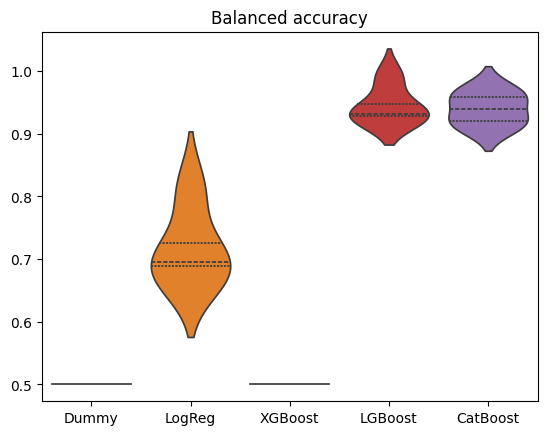

In [17]:
sns.violinplot(data=df_acc, inner="quart").set_title("Balanced accuracy")
df_acc.mean()

Dummy       0.000000
LogReg      0.572091
XGBoost     0.000000
LGBoost     0.861817
CatBoost    0.854783
dtype: float64

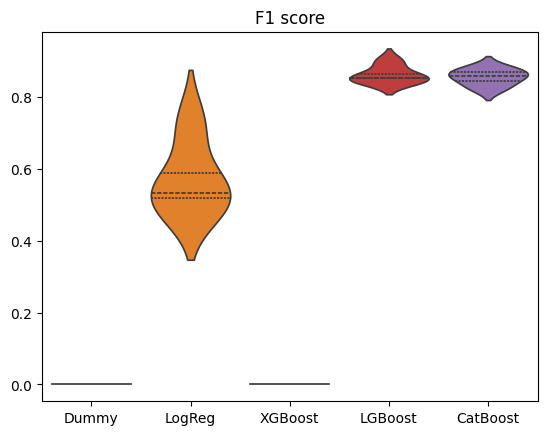

In [18]:
sns.violinplot(data=df_f1, inner="quart").set_title("F1 score")
df_f1.mean()

Dummy       0.500000
LogReg      0.981390
XGBoost     0.986638
LGBoost     0.989183
CatBoost    0.992879
dtype: float64

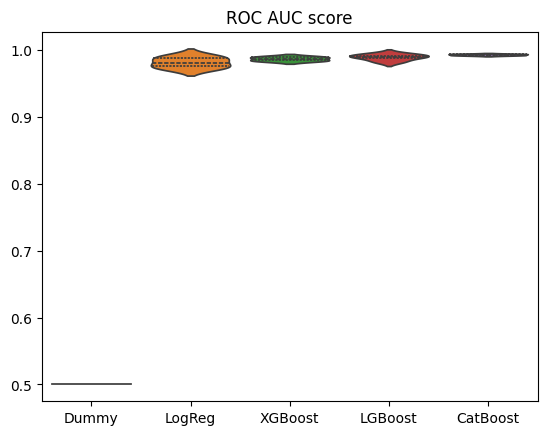

In [19]:
sns.violinplot(data=df_roc_auc, inner="quart").set_title("ROC AUC score")
df_roc_auc.mean()

In [20]:
def confison_matrix_plot(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=['lightgray'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=17)

In [22]:
model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
print(round(balanced_accuracy_score(y_pred, y_test.values),3))

0.797


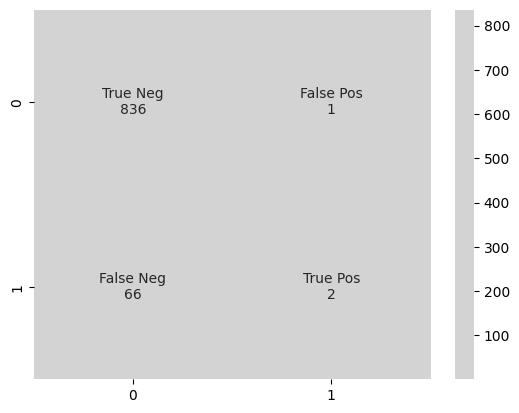

In [23]:
confison_matrix_plot(cf_matrix)

In [24]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
print(round(balanced_accuracy_score(y_pred, y_test.values),3))

0.818


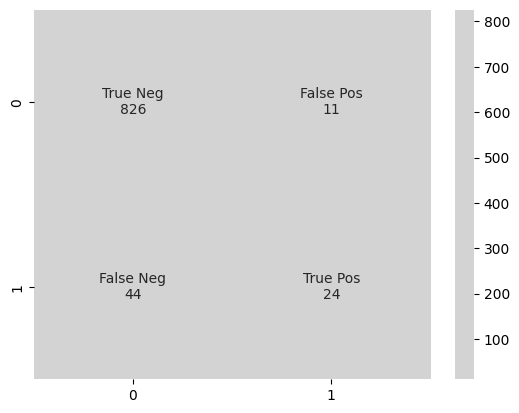

In [25]:
confison_matrix_plot(cf_matrix)

In [26]:
model = CatBoostClassifier(iterations=100,learning_rate=0.1,depth=6,verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
print(round(balanced_accuracy_score(y_pred, y_test.values),3))

0.891


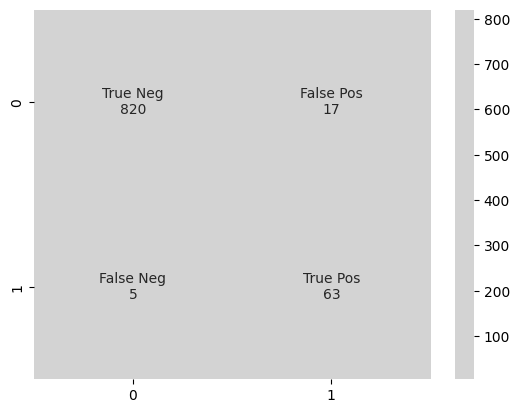

In [27]:
confison_matrix_plot(cf_matrix)

# 3. Глубокие нейросети
https://medium.com/@kdk199604/tabnet-a-deep-learning-breakthrough-for-tabular-data-bcd39c47a81c

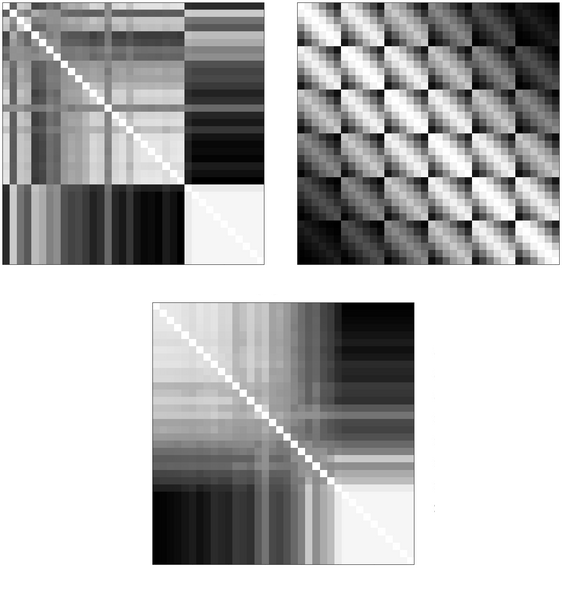

In [28]:
Image("figure3.png")

!pip install pytorch-tabnet

In [29]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=17)

model = TabNetClassifier()  #TabNetRegressor()
model.fit(X_train.values, y_train.values,eval_set=[(X_test.values, y_test.values)], eval_metric=['accuracy'])
y_pred = model.predict(X_test.values)
cf_matrix = confusion_matrix(y_test.values, y_pred)


C:\Users\demet\miniconda3\envs\torch_vis\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83083 | val_0_accuracy: 0.88398 |  0:00:00s
epoch 1  | loss: 0.451   | val_0_accuracy: 0.92376 |  0:00:00s
epoch 2  | loss: 0.32533 | val_0_accuracy: 0.92486 |  0:00:00s
epoch 3  | loss: 0.28336 | val_0_accuracy: 0.92486 |  0:00:00s
epoch 4  | loss: 0.28897 | val_0_accuracy: 0.92486 |  0:00:00s
epoch 5  | loss: 0.26798 | val_0_accuracy: 0.92486 |  0:00:00s
epoch 6  | loss: 0.26344 | val_0_accuracy: 0.92486 |  0:00:01s
epoch 7  | loss: 0.23427 | val_0_accuracy: 0.92486 |  0:00:01s
epoch 8  | loss: 0.22464 | val_0_accuracy: 0.92486 |  0:00:01s
epoch 9  | loss: 0.21752 | val_0_accuracy: 0.92155 |  0:00:01s
epoch 10 | loss: 0.22446 | val_0_accuracy: 0.92597 |  0:00:01s
epoch 11 | loss: 0.19997 | val_0_accuracy: 0.92928 |  0:00:01s
epoch 12 | loss: 0.19524 | val_0_accuracy: 0.93702 |  0:00:01s
epoch 13 | loss: 0.17779 | val_0_accuracy: 0.93481 |  0:00:01s
epoch 14 | loss: 0.18102 | val_0_accuracy: 0.93702 |  0:00:01s
epoch 15 | loss: 0.16818 | val_0_accuracy: 0.93481 |  0

C:\Users\demet\miniconda3\envs\torch_vis\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.85


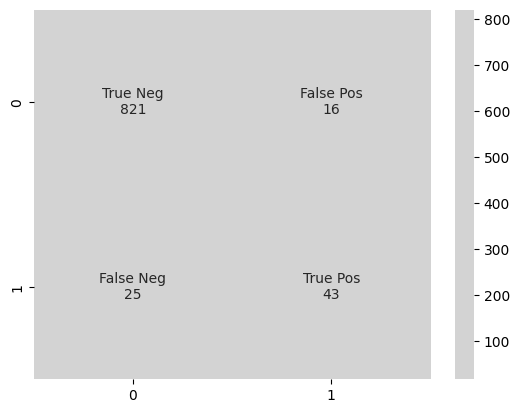

In [30]:
confison_matrix_plot(cf_matrix)
print(round(balanced_accuracy_score(y_pred, y_test.values),3))

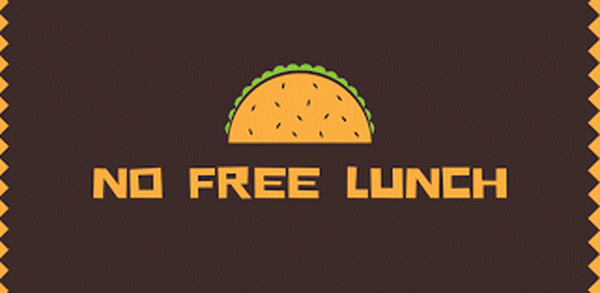

In [31]:
Image("figure4.png")